In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

### **Read Data**

In [ ]:
df_train  =  pd.read_csv('sample_data/train.csv', parse_dates=['date'])
df_oil = pd.read_csv('sample_data/oil.csv', parse_dates=['date'])
df_sample_submission = pd.read_csv('sample_data/sample_submission.csv')
df_stores = pd.read_csv('sample_data/stores.csv')
df_test = pd.read_csv('sample_data/test.csv', parse_dates=['date'])
df_transaction = pd.read_csv('sample_data/transactions.csv', parse_dates=['date'])
df_holidays_events = pd.read_csv('sample_data/holidays_events.csv', parse_dates=['date'])

### **Join the data**

In [ ]:
print(df_train.columns)
print(df_oil.columns)
print(df_sample_submission.columns)
print(df_stores.columns)
print(df_test.columns)
print(df_transaction.columns)
print(df_holidays_events.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Index(['date', 'dcoilwtico'], dtype='object')
Index(['id', 'sales'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')
Index(['date', 'store_nbr', 'transactions'], dtype='object')
Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')


In [ ]:
df = pd.concat([df_train, df_test])
# Merge train data with oil prices
df = pd.merge(df, df_oil, on='date', how='left')
# Merge with store information
df = pd.merge(df, df_stores, on='store_nbr', how='left')
# Merge with holidays and events
df = pd.merge(df, df_holidays_events, on='date', how='left')

In [ ]:
df.rename(columns={'type_x': 'type_store', 'type_y': 'type_holiday'}, inplace=True)

In [ ]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['holiday'] = df['type_holiday'].apply(lambda x: 1 if x == 'Holiday' else 0)
df['workday'] = df['type_holiday'].apply(lambda x: 1 if x == 'Work Day' else 0 )
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_store,...,type_holiday,locale,locale_name,description,transferred,month,year,day,holiday,workday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,...,Holiday,National,Ecuador,Primer dia del ano,False,1,2013,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,...,Holiday,National,Ecuador,Primer dia del ano,False,1,2013,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,...,Holiday,National,Ecuador,Primer dia del ano,False,1,2013,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,...,Holiday,National,Ecuador,Primer dia del ano,False,1,2013,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,...,Holiday,National,Ecuador,Primer dia del ano,False,1,2013,1,1,0


In [ ]:
df.drop(columns=['dcoilwtico', 'city', 'state','description','locale_name', 'type_holiday', 'type_store', 'locale'], inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_features = df.select_dtypes(include=['object']).columns
for feature in label_features:
     df[feature] = label_encoder.fit_transform(df[feature])

In [ ]:
data_train = df[:len(df_train)]
data_test =  df[len(df_train):]

In [ ]:
X = data_train.drop(['date', 'sales'], axis=1)
y = data_train['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
train_id = X_train['id']
val_id = X_val['id']
X_train = X_train.drop('id', axis=1)
X_val = X_val.drop('id', axis=1)

In [ ]:
# prompt: generate good Randomforest model with gridseach for X_train ..

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 3
}

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(**params,  n_jobs=-1, random_state=42)

# Create a GridSearchCV object
#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
#grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
#best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters and score
#print(f"Best hyperparameters: {grid_search.best_params_}")
#print(f"Best score (negative MSE): {grid_search.best_score_}")

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
X = data_test.drop(['date', 'sales'], axis=1)
y = data_test['sales']
test_id = X['id']
X_test = X.drop('id', axis=1)

In [ ]:
y_pred = rf_model.predict(X_val)

In [ ]:
submmission = pd.DataFrame({'id': val_id, 'sales': y_pred})
submmission.to_csv('submission.csv', index=False)

array([4.06100067e+00, 2.52302198e-01, 1.88764316e+00, ...,
       1.38476830e+03, 3.23019923e+01, 2.72366139e+01])

In [ ]:
# prompt: check if array contain nan value

import numpy as np

# Assuming 'X_train' is your array
if np.isnan(y_pred).any():
  print("X_train contains NaN values")
else:
  print("X_train does not contain NaN values")

X_train does not contain NaN values


In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)

  # Handle potential errors in MAPE calculation
  try:
      mape = mean_absolute_percentage_error(y_true, y_pred)
  except ValueError as e:
      if 'mean of an empty slice' in str(e):  # Handle cases with all zeros
          mape = float('inf')
      elif 'non-positive values' in str(e):  # Handle cases with negative values
          # Could implement a custom MAPE calculation that handles negatives,
          # but for now we'll just assign infinity
          mape = float('inf')
      else:
          raise # Re-raise other value errors

  metrics = {
      'MSE': mse,
      'MAE': mae,
      'MAPE': mape,
  }
  return metrics

# MASE calculation requires a naive forecast as a baseline
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast = y_train[:-1]  # naive forecast: previous value
    scale = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mean_absolute_error(y_true, y_pred) / scale
    return mase

In [ ]:
calculate_metrics(y_val, y_pred)

{'MSE': 232863.89778669574,
 'MAE': 121.4571731897939,
 'MAPE': 1.1164639045365858e+16}

In [ ]:
mean_absolute_scaled_error(y_val, y_pred, y_train)

0.22558298566664817

In [ ]:
def rmsle(y_true, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return rmsle

In [ ]:
rmsle(y_val, y_pred)

0.7534330355853883

In [ ]:
y_test_pred = rf.predict(X_test)

for i, val in enumerate(y_test_pred):
    if val < 0:
        y_test_pred[i] = 0

submission = pd.DataFrame()
submission['id'] = test_id
submission['sales'] = y_test_pred
submission.to_csv("submission.csv", index=False)
submission

### **Transform data**

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)
df_oil ['date']  = pd.to_datetime(df_oil['date'])
df_oil.set_index('date', inplace=True)
df_holidays_events.date = pd.to_datetime(df_holidays_events.date)
df_holidays_events.set_index('date', inplace=True)

### **Explore time series data**


In [ ]:
df_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


#### **Saisonality ,Trend Detection**

**Stationnarité, saisonnalité et tendance :**

Une série temporelle stationnaire a une moyenne, une variance et une autocorrélation constantes dans le temps. La stationnarité est une hypothèse importante pour de nombreux modèles de séries temporelles.
La saisonnalité est un modèle répétitif dans les données au fil du temps, généralement sur une base annuelle, trimestrielle ou mensuelle.
La tendance est une tendance générale à la hausse ou à la baisse des données au fil du temps.
Comment le test ADF nous aide-t-il à identifier la saisonnalité et la tendance ?

Si le test ADF indique que la série temporelle n'est pas stationnaire, cela pourrait être dû à une tendance ou à une saisonnalité. Pour confirmer, vous pouvez utiliser d'autres techniques telles que la décomposition saisonnière ou les statistiques roulantes.
Si la série temporelle n'est pas stationnaire en raison d'une tendance, vous devrez peut-être différencier la série (c'est-à-dire calculer la différence entre les observations consécutives) pour la rendre stationnaire avant d'appliquer des modèles de séries temporelles.
Si la série temporelle n'est pas stationnaire en raison d'une saisonnalité, vous devrez peut-être utiliser un modèle qui prend en compte la saisonnalité, tel qu'un modèle SARIMA.

In [ ]:
# Select store and family
i = 2

for f in df_train['family'].unique():

  # Filter data
  df_store_family = df_train[(df_train['store_nbr'] == i) & (df_train['family'] == f)]

  # Create the plot
  plt.figure(figsize=(12, 6))
  plt.plot(df_store_family.index, df_store_family['sales'])
  plt.xlabel('Date')
  plt.ylabel('Sales')
  plt.title(f'Sales of {f} at Store {i} over Time')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

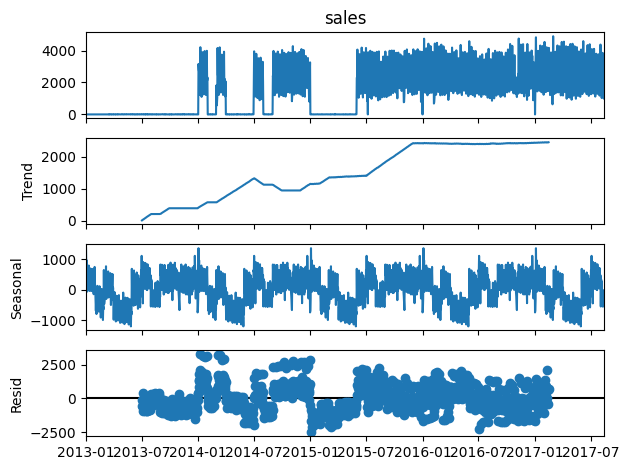

In [ ]:
# Sélectionner le magasin et la famille
store_nbr = 1
family = 'PRODUCE'

# Filtrer les données
filtered_df = df_train[(df_train['store_nbr'] == store_nbr) & (df_train['family'] == family)]

# Créer le tracé de décomposition saisonnière
result = seasonal_decompose(filtered_df['sales'], model='additive', period=365)

# Afficher le tracé
result.plot()
plt.show()

<ipython-input-29-3dd5ee6611e3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['rolling_mean'] = filtered_df['sales'].rolling(window=365).mean()
<ipython-input-29-3dd5ee6611e3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['rolling_std'] = filtered_df['sales'].rolling(window=365).std()


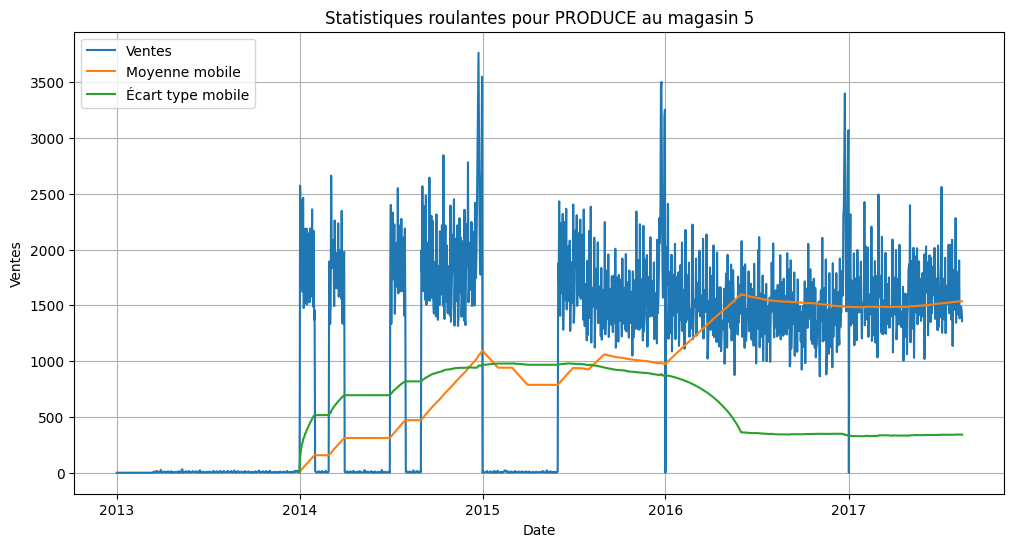

In [ ]:
# Sélectionner le magasin et la famille
store_nbr = 5
family = 'PRODUCE'

# Filtrer les données
filtered_df = df_train[(df_train['store_nbr'] == store_nbr) & (df_train['family'] == family)]

# Calculer la moyenne mobile
filtered_df['rolling_mean'] = filtered_df['sales'].rolling(window=365).mean()

# Calculer l'écart type mobile
filtered_df['rolling_std'] = filtered_df['sales'].rolling(window=365).std()

# Tracer les statistiques roulantes
plt.figure(figsize=(12, 6))
plt.plot(filtered_df.index, filtered_df['sales'], label='Ventes')
plt.plot(filtered_df.index, filtered_df['rolling_mean'], label='Moyenne mobile')
plt.plot(filtered_df.index, filtered_df['rolling_std'], label='Écart type mobile')
plt.title(f'Statistiques roulantes pour {family} au magasin {store_nbr}')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True)
plt.show()

### **Saisonality Testing**
 Dickey-Fuller Test (ADF Test)

 - Hypothèse nulle : La série temporelle a une racine unitaire (c'est-à-dire qu'elle n'est pas stationnaire).
 - Hypothèse alternative : La série temporelle n'a pas de racine unitaire (c'est-à-dire qu'elle est stationnaire).

In [ ]:
# Sélectionner le magasin et la famille
store_nbr = 1
family = 'PRODUCE'

# Filtrer les données
filtered_df = df_train[(df_train['store_nbr'] == store_nbr) & (df_train['family'] == family)]

# Extraire la colonne 'sales' pour le test ADF
sales_data = filtered_df['sales']
result = adfuller(sales_data)

print('Statistique ADF :', result[0])
print('Valeur p :', result[1])
print('Valeurs critiques :', result[4])

Statistique ADF : -3.385244016436383
Valeur p : 0.011472306105574811
Valeurs critiques : {'1%': -3.434300212992577, '5%': -2.863284793874921, '10%': -2.567698886736967}


In [ ]:
# prompt: i want to  use prophet as model . i have column called clusted that group store  and i also have a column for familly product.. and i have also a test_data with same columns like train but need to predict sales.... with multiprocessing

import pandas as pd
from prophet import Prophet
from multiprocessing import Pool, cpu_count
import numpy as np

# Assuming df_train and df_test are already loaded and preprocessed as in your provided code
# ... (Your existing code for data loading and preprocessing) ...


def train_predict_prophet(args):
    cluster, family, train_df, test_df = args

    # Filter data for specific cluster and family
    train_data = train_df[(train_df['cluster'] == cluster) & (train_df['family'] == family)].copy()
    test_data = test_df[(test_df['cluster'] == cluster) & (test_df['family'] == family)].copy()

    # Prophet requires 'ds' and 'y' columns
    train_data = train_data[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
    test_data = test_data[['date', 'id']].rename(columns={'date': 'ds'})

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train_data)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data))

    # Make predictions
    forecast = model.predict(future)

    # Extract predictions for the test period
    predictions = forecast[['ds', 'yhat']][-len(test_data):].rename(columns={'ds': 'date', 'yhat': 'sales'})
    predictions = pd.merge(predictions, test_data, on='date', how='left')

    return predictions[['id', 'sales']]

if __name__ == '__main__':  # Important for multiprocessing
    # Prepare the arguments for multiprocessing
    groups = []
    for cluster in df_train['cluster'].unique():
      for family in df_train['family'].unique():
          groups.append((cluster, family, df_train, df_test))

    # Use multiprocessing to run the model on each cluster/family group
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(train_predict_prophet, groups)

    # Combine the results
    final_predictions = pd.concat(results)

    # Ensure predictions are not negative
    final_predictions['sales'] = np.maximum(0, final_predictions['sales'])

    final_predictions.to_csv('prophet_submission.csv', index=False)


<Figure size 1200x600 with 0 Axes>

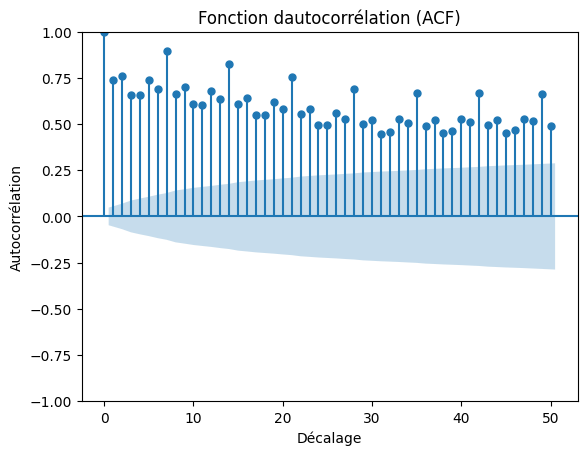

<Figure size 1200x600 with 0 Axes>

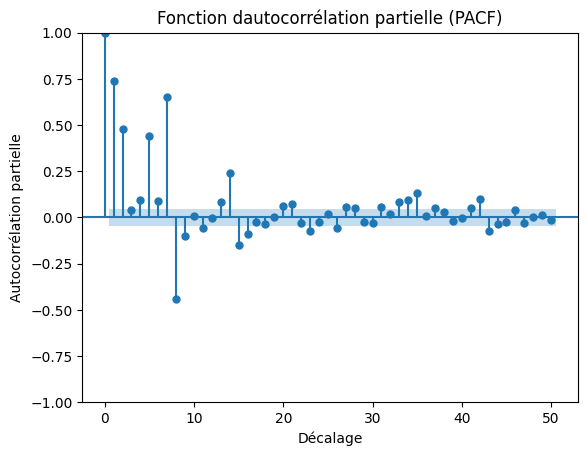

In [ ]:
# Tracer l'ACF
plt.figure(figsize=(12, 6))
plot_acf(sales_data, lags=50)  # Ajustez 'lags' selon vos besoins
plt.title('Fonction dautocorrélation (ACF)')
plt.xlabel('Décalage')
plt.ylabel('Autocorrélation')
plt.show()

# Tracer la PACF
plt.figure(figsize=(12, 6))
plot_pacf(sales_data, lags=50)  # Ajustez 'lags' selon vos besoins
plt.title('Fonction dautocorrélation partielle (PACF)')
plt.xlabel('Décalage')
plt.ylabel('Autocorrélation partielle')
plt.show()

In [ ]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
